<a href="https://colab.research.google.com/github/jasonbrelsford/Auto-GPT/blob/master/standalone_updload_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File 'update-patient-hla.json' created successfully.
200
{'resourceType': 'Bundle', 'id': '3e735f45-08c3-4ab7-ae52-2b5c31a63e9a', 'type': 'transaction-response', 'link': [{'relation': 'self', 'url': 'https://hapi.fhir.org/baseR4'}], 'entry': [{'response': {'status': '201 Created', 'location': 'Patient/45088613/_history/1', 'etag': '1', 'lastModified': '2024-10-22T16:35:54.916+00:00', 'outcome': {'resourceType': 'OperationOutcome', 'text': {'status': 'generated', 'div': '<div xmlns="http://www.w3.org/1999/xhtml"><h1>Operation Outcome</h1><table border="0"><tr><td style="font-weight: bold;">INFORMATION</td><td>[]</td><td>Successfully created resource &quot;Patient/45088613/_history/1&quot;. Took 22ms.</td></tr></table></div>'}, 'issue': [{'severity': 'information', 'code': 'informational', 'details': {'coding': [{'system': 'https://hapifhir.io/fhir/CodeSystem/hapi-fhir-storage-response-code', 'code': 'SUCCESSFUL_CREATE', 'display': 'Create succeeded.'}]}, 'diagnostics': 'Successfully cre

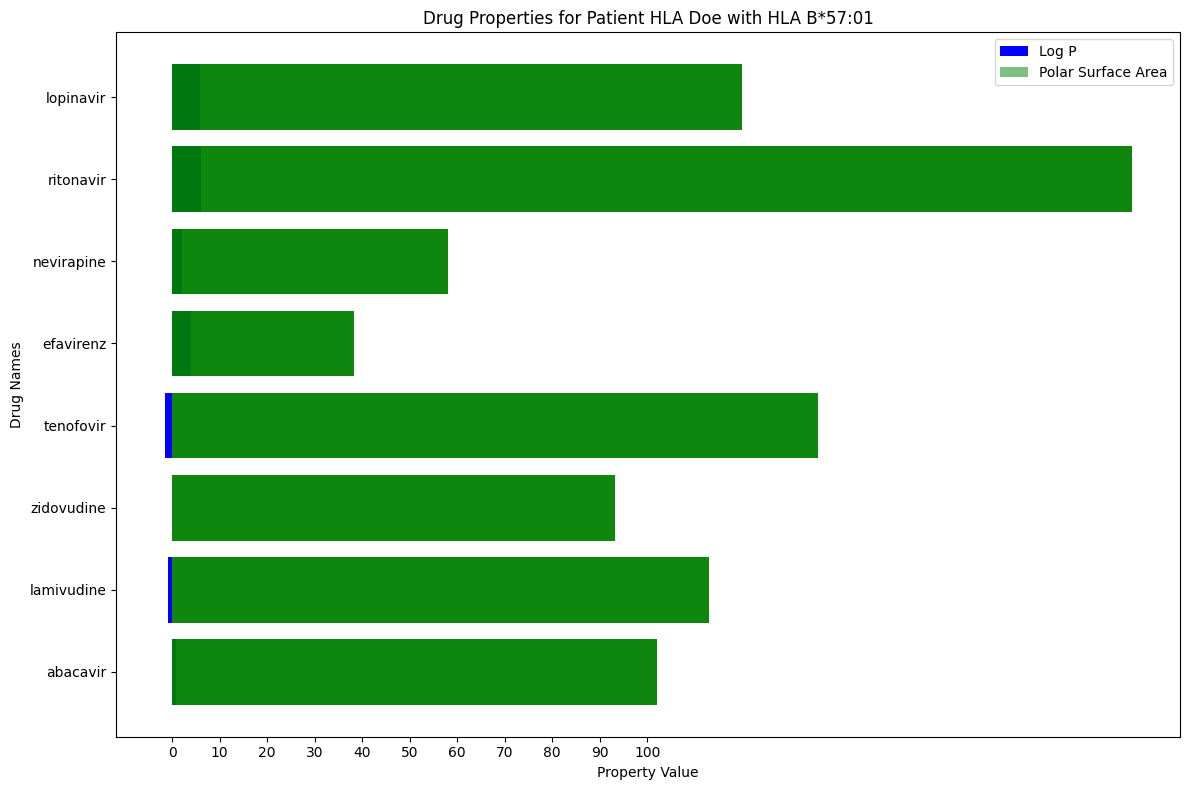

In [ ]:
import requests
import matplotlib.pyplot as plt
import json  # Import the json module

#Submit HLA data to public FHIR server so that we have HLA to use for lookup
# Define the JSON content

json_content = {
    "resourceType": "Bundle",
    "id": "22",
    "type": "transaction",
    "entry": [
        {
            "fullUrl": "https://hapi.fhir.org/baseR4/example-patient",
            "resource": {
                "resourceType": "Patient",
                "id": "example-patient",
                "name": [
                    {
                        "use": "official",
                        "family": "Doe",
                        "given": ["HLA"]
                    }
                ],
                "gender": "male",
                "birthDate": "1980-01-01",
                "extension": [
                    {
                        "url": "http://hl7.org/fhir/StructureDefinition/hla-typing",
                        "valueString": "HLA-A*01:01, HLA-B*57:01, HLA-DRB1*04:01"
                    }
                ]
            },
            "request": {
                "method": "POST",
                "url": "Patient"
            }
        }
    ]
}

# Write the JSON content to a file
with open('update-patient-hla.json', 'w') as json_file:
    json.dump(json_content, json_file, indent=2)

print("File 'update-patient-hla.json' created successfully.")


# Load JSON data from the file
with open('update-patient-hla.json', 'r') as file:
    data = json.load(file)

# Set the endpoint URL
url = 'https://hapi.fhir.org/baseR4/'

# Set the headers
headers = {
    'accept': 'application/fhir+json',
    'Content-Type': 'application/fhir+json',
}

# Send the POST request
response = requests.post(url, headers=headers, json=data)

# Print the response
print(response.status_code)  # Print the status code
print(response.json())        # Print the response JSON if applicable



def search_patient_hla_doe():
    """Search for the specific patient 'HLA Doe' on the HAPI FHIR server."""
    fhir_url = "https://hapi.fhir.org/baseR4/Patient?name=HLA"

    try:
        response = requests.get(fhir_url)
        response.raise_for_status()  # Check for HTTP errors

        data = response.json()
        return data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching patient data from FHIR server: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching patient data from FHIR server: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching patient data from FHIR server: {e}")


def search_pubchem_for_drug_properties(drug_name):
    """Fetch relevant properties of a drug from PubChem and handle errors gracefully."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        compound_data = response.json()
        props = compound_data.get('PC_Compounds', [{}])[0].get('props', [])

        # Extract relevant properties from the response, handling missing data
        hydrogen_bond_acceptor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Acceptor'), None)
        hydrogen_bond_donor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Donor'), None)
        log_p = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') in ['XLogP3', 'XLogP3-AA']), None)
        polar_surface_area = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') == 'Polar Surface Area'), None)
        molecular_weight = next((prop['value']['sval'] for prop in props if prop.get('urn', {}).get('name') == 'Molecular Weight'), None)

        return {
            'Hydrogen Bond Acceptor': hydrogen_bond_acceptor,
            'Hydrogen Bond Donor': hydrogen_bond_donor,
            'Log P': log_p,
            'Polar Surface Area': polar_surface_area,
            'Molecular Weight': molecular_weight
        }
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except KeyError as key_err:
        print(f"KeyError while fetching data from PubChem: {key_err} - raw data: {compound_data}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e} - raw data: {compound_data}")
        return None

def correlate_patient_with_drug_properties(patient_data, drug_list):
    """Correlate the specific patient with the properties of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            drug_properties = search_pubchem_for_drug_properties(drug)
            if drug_properties is not None:
                results.append((patient_name, drug, hla_typing, drug_properties))
            else:
                print(f"No valid data found for {drug}.")

    return results

def plot_drug_properties(results):
    """Plot the drug properties for visualization."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]

    # Extracting specific properties for plotting
    log_p_values = [item[3].get('Log P', 0) for item in hla_detected]
    psa_values = [item[3].get('Polar Surface Area', 0) for item in hla_detected]

    plt.figure(figsize=(12, 8))
    plt.barh(drug_names, log_p_values, color='blue', label='Log P')
    plt.barh(drug_names, psa_values, color='green', alpha=0.5, label='Polar Surface Area')

    # Increase the x-axis granularity to show values from 0 to 100
    plt.xticks(range(0, 101, 10))

    plt.xlabel('Property Value')
    plt.ylabel('Drug Names')
    plt.title('Drug Properties for Patient HLA Doe with HLA B*57:01')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: Expanded list of drugs to check properties in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine', 'tenofovir', 'efavirenz', 'nevirapine', 'ritonavir', 'lopinavir']

    # Step 3: Correlate the patient's HLA B*57:01 status with drug properties
    results = correlate_patient_with_drug_properties(patient_data, drug_list)

    # Step 4: Plot the results
    plot_drug_properties(results)

File 'update-patient-hla.json' created successfully.
200
{'resourceType': 'Bundle', 'id': '47c18b62-0623-4662-83a7-b124f02c81c1', 'type': 'transaction-response', 'link': [{'relation': 'self', 'url': 'https://hapi.fhir.org/baseR4'}], 'entry': [{'response': {'status': '201 Created', 'location': 'Patient/45088614/_history/1', 'etag': '1', 'lastModified': '2024-10-22T16:42:43.901+00:00', 'outcome': {'resourceType': 'OperationOutcome', 'text': {'status': 'generated', 'div': '<div xmlns="http://www.w3.org/1999/xhtml"><h1>Operation Outcome</h1><table border="0"><tr><td style="font-weight: bold;">INFORMATION</td><td>[]</td><td>Successfully created resource &quot;Patient/45088614/_history/1&quot;. Took 23ms.</td></tr></table></div>'}, 'issue': [{'severity': 'information', 'code': 'informational', 'details': {'coding': [{'system': 'https://hapifhir.io/fhir/CodeSystem/hapi-fhir-storage-response-code', 'code': 'SUCCESSFUL_CREATE', 'display': 'Create succeeded.'}]}, 'diagnostics': 'Successfully cre

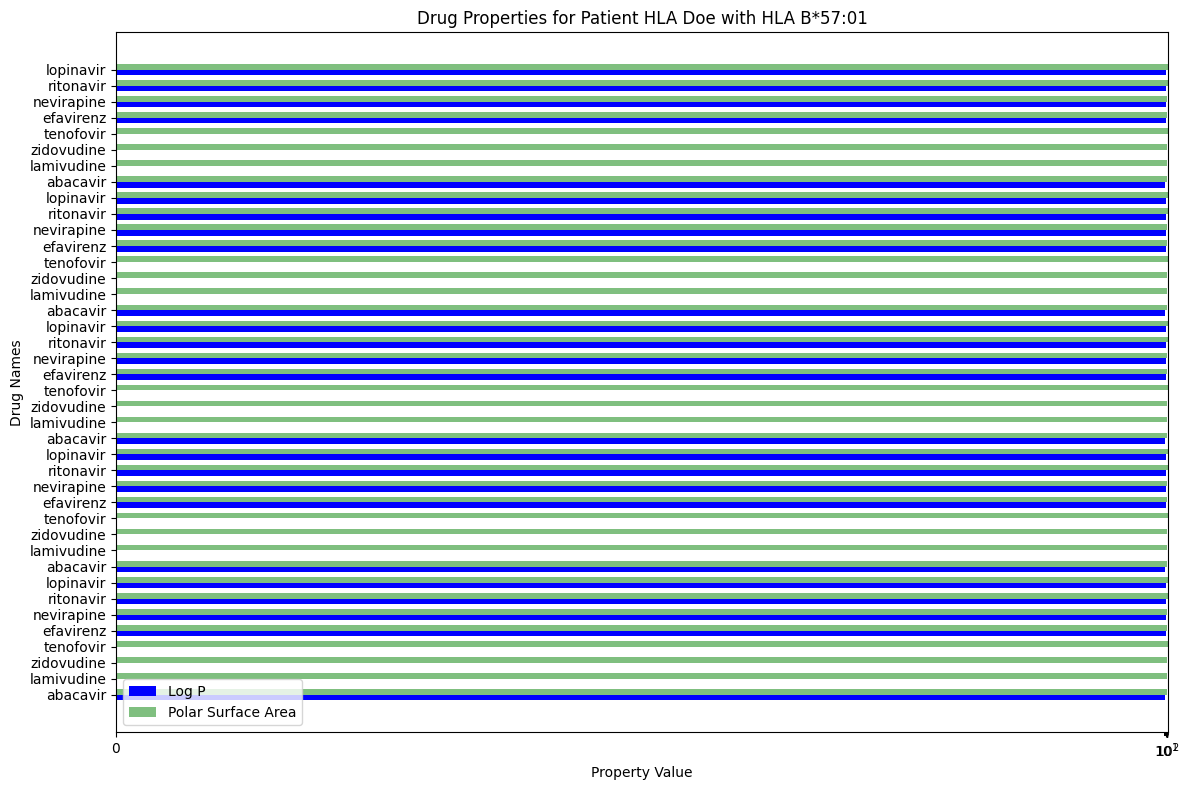

In [ ]:
import requests
import matplotlib.pyplot as plt
import json  # Import the json module
import numpy as np

# Submit HLA data to public FHIR server so that we have HLA to use for lookup
# Define the JSON content
json_content = {
    "resourceType": "Bundle",
    "id": "22",
    "type": "transaction",
    "entry": [
        {
            "fullUrl": "https://hapi.fhir.org/baseR4/example-patient",
            "resource": {
                "resourceType": "Patient",
                "id": "example-patient",
                "name": [
                    {
                        "use": "official",
                        "family": "Doe",
                        "given": ["HLA"]
                    }
                ],
                "gender": "male",
                "birthDate": "1980-01-01",
                "extension": [
                    {
                        "url": "http://hl7.org/fhir/StructureDefinition/hla-typing",
                        "valueString": "HLA-A*01:01, HLA-B*57:01, HLA-DRB1*04:01"
                    }
                ]
            },
            "request": {
                "method": "POST",
                "url": "Patient"
            }
        }
    ]
}

# Write the JSON content to a file
with open('update-patient-hla.json', 'w') as json_file:
    json.dump(json_content, json_file, indent=2)

print("File 'update-patient-hla.json' created successfully.")

# Load JSON data from the file
with open('update-patient-hla.json', 'r') as file:
    data = json.load(file)

# Set the endpoint URL
url = 'https://hapi.fhir.org/baseR4/'

# Set the headers
headers = {
    'accept': 'application/fhir+json',
    'Content-Type': 'application/fhir+json',
}

# Send the POST request
response = requests.post(url, headers=headers, json=data)

# Print the response
print(response.status_code)  # Print the status code
print(response.json())        # Print the response JSON if applicable

def search_patient_hla_doe():
    """Search for the specific patient 'HLA Doe' on the HAPI FHIR server."""
    fhir_url = "https://hapi.fhir.org/baseR4/Patient?name=HLA"

    try:
        response = requests.get(fhir_url)
        response.raise_for_status()  # Check for HTTP errors

        data = response.json()
        return data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching patient data from FHIR server: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching patient data from FHIR server: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching patient data from FHIR server: {e}")

def search_pubchem_for_drug_properties(drug_name):
    """Fetch relevant properties of a drug from PubChem and handle errors gracefully."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        compound_data = response.json()
        props = compound_data.get('PC_Compounds', [{}])[0].get('props', [])

        # Extract relevant properties from the response, handling missing data
        hydrogen_bond_acceptor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Acceptor'), None)
        hydrogen_bond_donor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Donor'), None)
        log_p = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') in ['XLogP3', 'XLogP3-AA']), None)
        polar_surface_area = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') == 'Polar Surface Area'), None)
        molecular_weight = next((prop['value']['sval'] for prop in props if prop.get('urn', {}).get('name') == 'Molecular Weight'), None)

        return {
            'Hydrogen Bond Acceptor': hydrogen_bond_acceptor,
            'Hydrogen Bond Donor': hydrogen_bond_donor,
            'Log P': log_p,
            'Polar Surface Area': polar_surface_area,
            'Molecular Weight': molecular_weight
        }
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except KeyError as key_err:
        print(f"KeyError while fetching data from PubChem: {key_err} - raw data: {compound_data}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e} - raw data: {compound_data}")
        return None

def correlate_patient_with_drug_properties(patient_data, drug_list):
    """Correlate the specific patient with the properties of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            drug_properties = search_pubchem_for_drug_properties(drug)
            if drug_properties is not None:
                results.append((patient_name, drug, hla_typing, drug_properties))
            else:
                print(f"No valid data found for {drug}.")

    return results

def plot_drug_properties(results):
    """Plot the drug properties for visualization."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]

    # Extracting specific properties for plotting
    log_p_values = [item[3].get('Log P', 0) for item in hla_detected]
    psa_values = [item[3].get('Polar Surface Area', 0) for item in hla_detected]

    index = np.arange(len(drug_names))
    bar_width = 0.35

    plt.figure(figsize=(12, 8))

    # Side-by-side bars for better comparison
    plt.barh(index, log_p_values, bar_width, color='blue', label='Log P')
    plt.barh(index + bar_width, psa_values, bar_width, color='green', alpha=0.5, label='Polar Surface Area')

    # Set y-axis labels
    plt.yticks(index + bar_width / 2, drug_names)

    # Logarithmic scale for x-axis
    plt.xscale('log')

    # Increase the x-axis granularity
    plt.xticks(range(0, 101, 10))

    plt.xlabel('Property Value')
    plt.ylabel('Drug Names')
    plt.title('Drug Properties for Patient HLA Doe with HLA B*57:01')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: Expanded list of drugs to check properties in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine', 'tenofovir', 'efavirenz', 'nevirapine', 'ritonavir', 'lopinavir']

    # Step 3: Correlate the patient's HLA B*57:01 status with drug properties
    results = correlate_patient_with_drug_properties(patient_data, drug_list)

    # Step 4: Plot the results
    plot_drug_properties(results)


In [ ]:
import requests
import matplotlib.pyplot as plt
import json
import numpy as np

# Submit HLA data to public FHIR server so that we have HLA to use for lookup
# Define the JSON content
json_content = {
    "resourceType": "Bundle",
    "id": "22",
    "type": "transaction",
    "entry": [
        {
            "fullUrl": "https://hapi.fhir.org/baseR4/example-patient",
            "resource": {
                "resourceType": "Patient",
                "id": "example-patient",
                "name": [
                    {
                        "use": "official",
                        "family": "Doe",
                        "given": ["HLA"]
                    }
                ],
                "gender": "male",
                "birthDate": "1980-01-01",
                "extension": [
                    {
                        "url": "http://hl7.org/fhir/StructureDefinition/hla-typing",
                        "valueString": "HLA-A*01:01, HLA-B*57:01, HLA-DRB1*04:01"
                    }
                ]
            },
            "request": {
                "method": "POST",
                "url": "Patient"
            }
        }
    ]
}

# Write the JSON content to a file
with open('update-patient-hla.json', 'w') as json_file:
    json.dump(json_content, json_file, indent=2)

print("File 'update-patient-hla.json' created successfully.")

# Load JSON data from the file
with open('update-patient-hla.json', 'r') as file:
    data = json.load(file)

# Set the endpoint URL
url = 'https://hapi.fhir.org/baseR4/'

# Set the headers
headers = {
    'accept': 'application/fhir+json',
    'Content-Type': 'application/fhir+json',
}

# Send the POST request
response = requests.post(url, headers=headers, json=data)

# Print the response
print(response.status_code)  # Print the status code
print(response.json())        # Print the response JSON if applicable

def search_patient_hla_doe():
    """Search for the specific patient 'HLA Doe' on the HAPI FHIR server."""
    fhir_url = "https://hapi.fhir.org/baseR4/Patient?name=HLA"

    try:
        response = requests.get(fhir_url)
        response.raise_for_status()  # Check for HTTP errors

        data = response.json()
        return data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching patient data from FHIR server: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching patient data from FHIR server: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching patient data from FHIR server: {e}")

def search_pubchem_for_drug_properties(drug_name):
    """Fetch relevant properties of a drug from PubChem and handle errors gracefully."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        compound_data = response.json()
        props = compound_data.get('PC_Compounds', [{}])[0].get('props', [])

        # Extract relevant properties from the response, handling missing data
        hydrogen_bond_acceptor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Acceptor'), None)
        hydrogen_bond_donor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Donor'), None)
        log_p = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') in ['XLogP3', 'XLogP3-AA']), None)
        polar_surface_area = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') == 'Polar Surface Area'), None)
        molecular_weight = next((prop['value']['sval'] for prop in props if prop.get('urn', {}).get('name') == 'Molecular Weight'), None)

        return {
            'Hydrogen Bond Acceptor': hydrogen_bond_acceptor,
            'Hydrogen Bond Donor': hydrogen_bond_donor,
            'Log P': log_p,
            'Polar Surface Area': polar_surface_area,
            'Molecular Weight': molecular_weight
        }
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except KeyError as key_err:
        print(f"KeyError while fetching data from PubChem: {key_err} - raw data: {compound_data}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e} - raw data: {compound_data}")
        return None

def correlate_patient_with_drug_properties(patient_data, drug_list):
    """Correlate the specific patient with the properties of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            drug_properties = search_pubchem_for_drug_properties(drug)
            if drug_properties is not None:
                results.append((patient_name, drug, hla_typing, drug_properties))
            else:
                print(f"No valid data found for {drug}.")

    return results

def plot_drug_properties(results):
    """Plot the drug properties for visualization."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = list({item[1] for item in hla_detected})  # Ensure unique drug names

    # Extracting specific properties for plotting
    log_p_values = [item[3].get('Log P', 0) for item in hla_detected]
    psa_values = [item[3].get('Polar Surface Area', 0) for item in hla_detected]

    index = np.arange(len(drug_names))
    bar_width = 0.35

    plt.figure(figsize=(12, 8))

    # Plot the bars side by side, ensuring no repetition of drug names
    plt.barh(index, log_p_values[:len(drug_names)], bar_width, color='blue', label='Log P')
    plt.barh(index + bar_width, psa_values[:len(drug_names)], bar_width, color='green', alpha=0.5, label='Polar Surface Area')

    # Set y-axis labels
    plt.yticks(index + bar_width / 2, drug_names)

    # Increase the x-axis granularity
    plt.xticks(range(0, 101, 10))

    plt.xlabel('Property Value')
    plt.ylabel('Drug Names')
    plt.title('Drug Properties for Patient HLA Doe with HLA B*57:01')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: Expanded list of drugs to check properties in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine', 'tenofovir', 'efavirenz', 'nevirapine', 'ritonavir', 'lopinavir']

    # Step 3: Correlate the patient's HLA B*57:01 status with drug properties
    results = correlate_patient_with_drug_properties(patient_data, drug_list)

    # Step 4: Plot the results
    plot_drug_properties(results)


SyntaxError: invalid non-printable character U+00A0 (<ipython-input-7-efdb0048db69>, line 9)